## TODO


### Imports

In [1]:
import pandas
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [100,20]
np.set_printoptions(suppress=True)

In [2]:
def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pandas.options.display

    display.max_columns = 1000
    display.max_rows = 100
    display.max_colwidth = 199
    display.width = None
    display.float_format = '{:.2f}'.format
    # display.precision = 2  # set as needed
set_pandas_display_options()

In [3]:
path = "~/work/data/producer-f4tqh/2020-09-16_17-53-53"
topic = "t2"
full_path = path + "/" + topic

## Filter

In [4]:
def dropFirstXRows(input, x):
    return input.drop(np.arange(0,x))

def removeNaN(array, array2):
    helper = np.logical_not(np.isnan(array))
    return array[helper], array2[helper]

In [5]:
produced_generated_df = pandas.read_csv(full_path + "_produced.csv")
produced_recieved_df = pandas.read_csv(full_path + ".csv")
filtered_df = pandas.read_csv(full_path + "_filtered.csv")
warnings_df = pandas.read_csv(full_path + "_warnings.csv")
modelchange_df = pandas.read_csv(full_path + "_modelchange.csv")

elementsToDrop = 0#10000
produced_generated_df = dropFirstXRows(produced_generated_df,elementsToDrop)
produced_recieved_df = dropFirstXRows(produced_recieved_df,elementsToDrop)
filtered_df = dropFirstXRows(filtered_df,elementsToDrop)

#drop changes before first element
#modelchange_df = modelchange_df[modelchange_df.iloc[:,0] >= produced_generated_df.iloc[0][2]]

# drop endtime in warning before first element
#warnings_df = warnings_df[warnings_df.iloc[:,6] >= produced_generated_df.iloc[0][2]]
firstTimestamp = produced_generated_df.iloc()[0][3]

### Helper

In [21]:
def plotDistribution(data, timestamps):
    #plt.scatter(np.arange(1,len(data) + 1,1), data, s = 1)
    #plt.plot(np.arange(1,len(data) + 1,1), data)
    plt.plot((timestamps - firstTimestamp) / 60000, data)
    #plt.yscale("log")
    #plt.ylim(0,10)
    #plt.xlim(0,100
    plt.xlabel("Time in min")
    plt.show()
    
    sorted = np.sort(data)
    plt.yscale("log")

    plt.plot(np.linspace(0, 1,len(sorted),endpoint=True), sorted)
    plt.xlabel("Time in min")
    plt.show()

In [7]:
def extractAvgMedStdMinMaxFromArray(diff, timestamps):
    plotDistribution(diff, timestamps)
    return "avg = %.2f ms; median %.2f ms; std %.2f ms; min %d ms; max %d ms; 90%% %.2f ms; 95%% %.2f ms; 99%% %.2f ms; 99.9%% %.2f ms"\
        %(np.average(diff), np.median(diff), np.std(diff), np.min(diff), np.max(diff), np.percentile(diff, 90), np.percentile(diff, 95), np.percentile(diff, 99), np.percentile(diff, 99.9))

### Histogram of generated data over time

consumer & produducer timestamp of the produced data

data isn't produced every 5ms instead there are peaks and lows, just the avg is 5ms

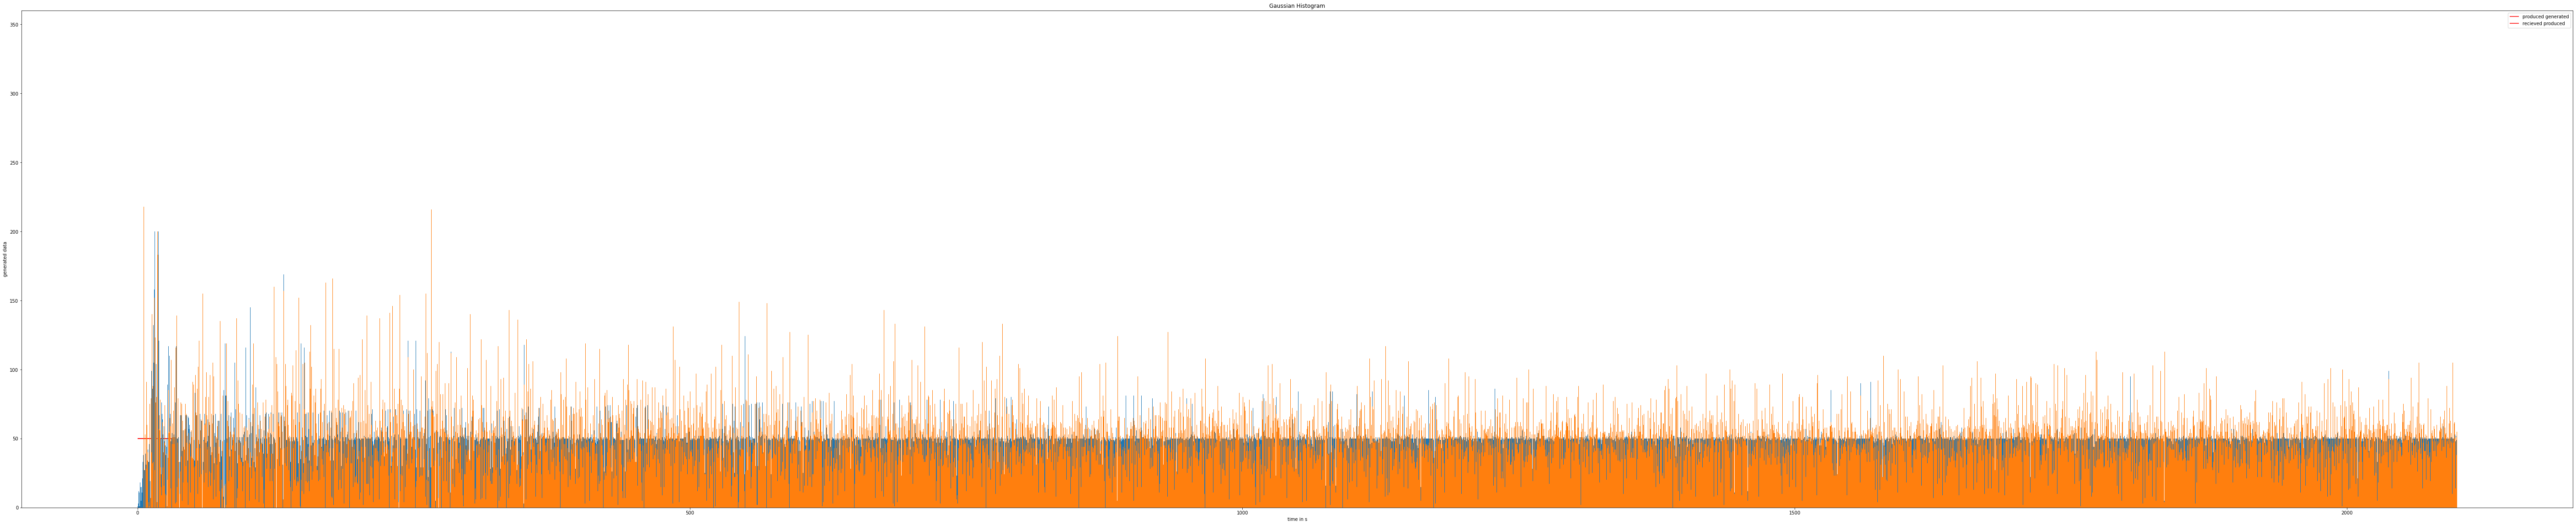

In [22]:
def plotHist(data, label, width = 250):
    timespan = data[-1] - data[0]
    
    
    
    plt.hist((data - firstTimestamp) / 1000, bins = int(timespan / width),zorder=2)
    plt.hlines(width / 5, 0, (data[-1] - firstTimestamp) / 60000, color = "red", label = label, zorder=1)
    plt.title("Gaussian Histogram")
    plt.xlabel("time in s")
    plt.ylabel("generated data")
    plt.legend()
    #plt.show()

producedTime = produced_generated_df.to_numpy()[:,3]
#print("Produced data distribution")
plotHist(producedTime, "produced generated") 
#print("Recieved produced data distribution")
plotHist(produced_recieved_df.to_numpy()[:,0], "recieved produced")
plt.show()



### Information on the time difference between the arival time of records for all 3 topics

peaks caused by cpu time, it is not regulary produced

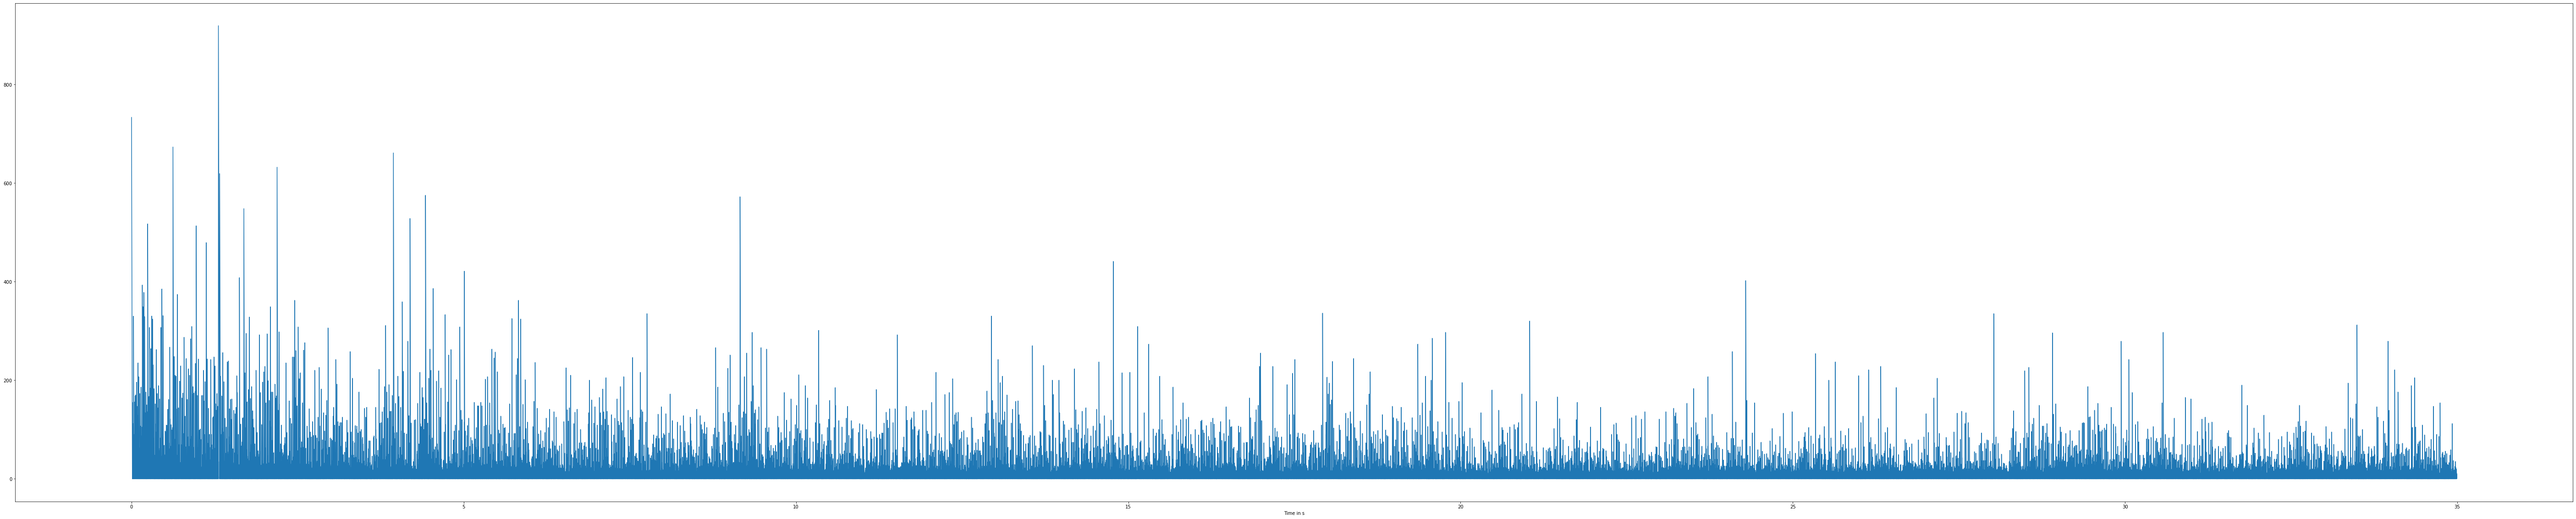

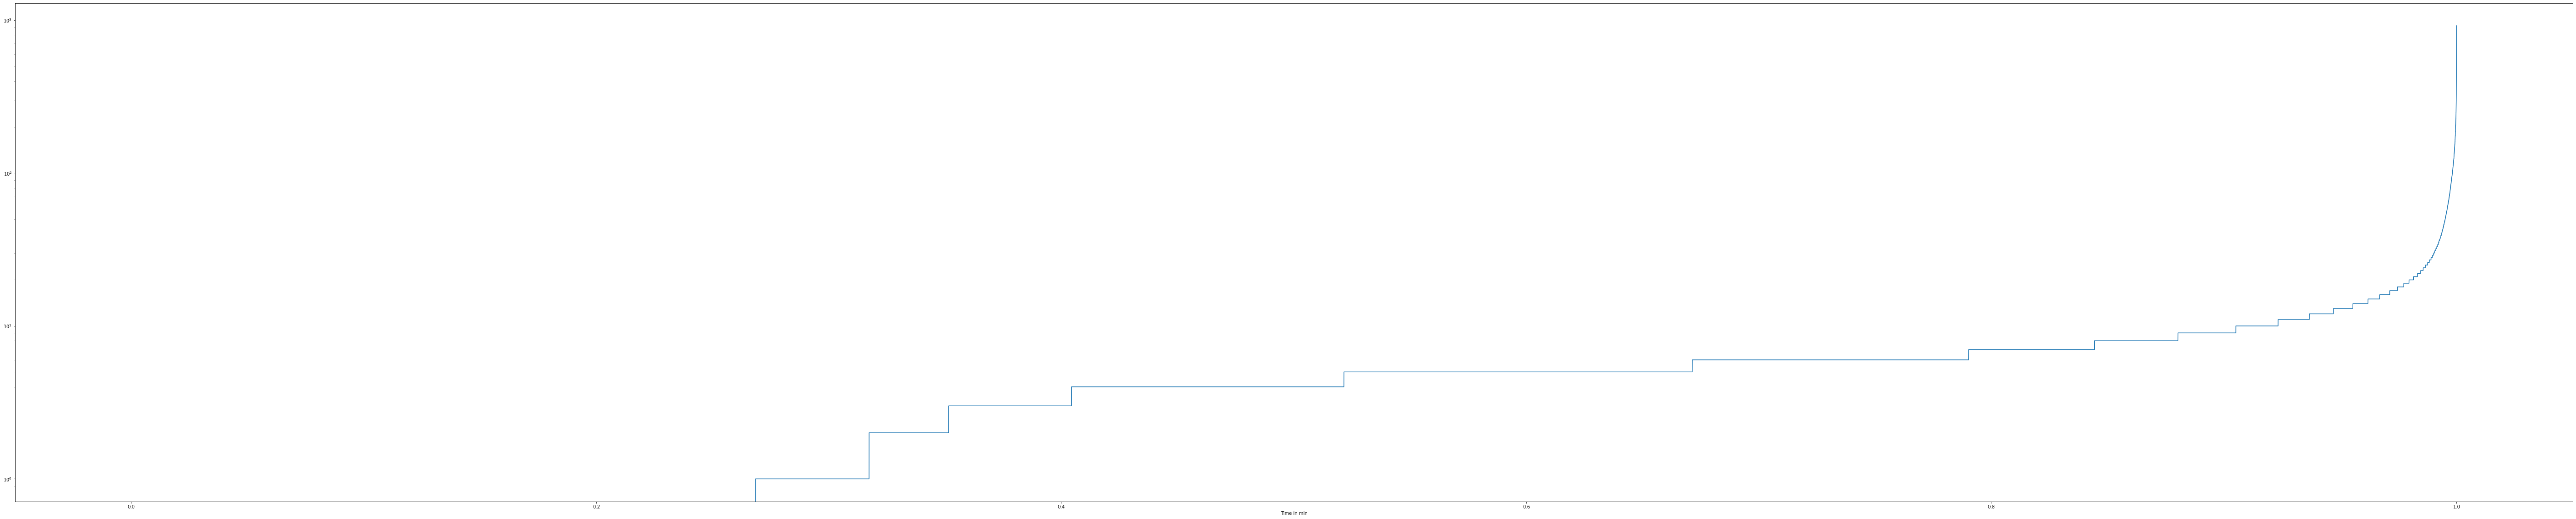

produced:
Got avg = 5.00 ms; median 4.00 ms; std 9.98 ms; min 0 ms; max 919 ms; 90% 9.00 ms; 95% 13.00 ms; 99% 29.00 ms; 99.9% 135.00 ms




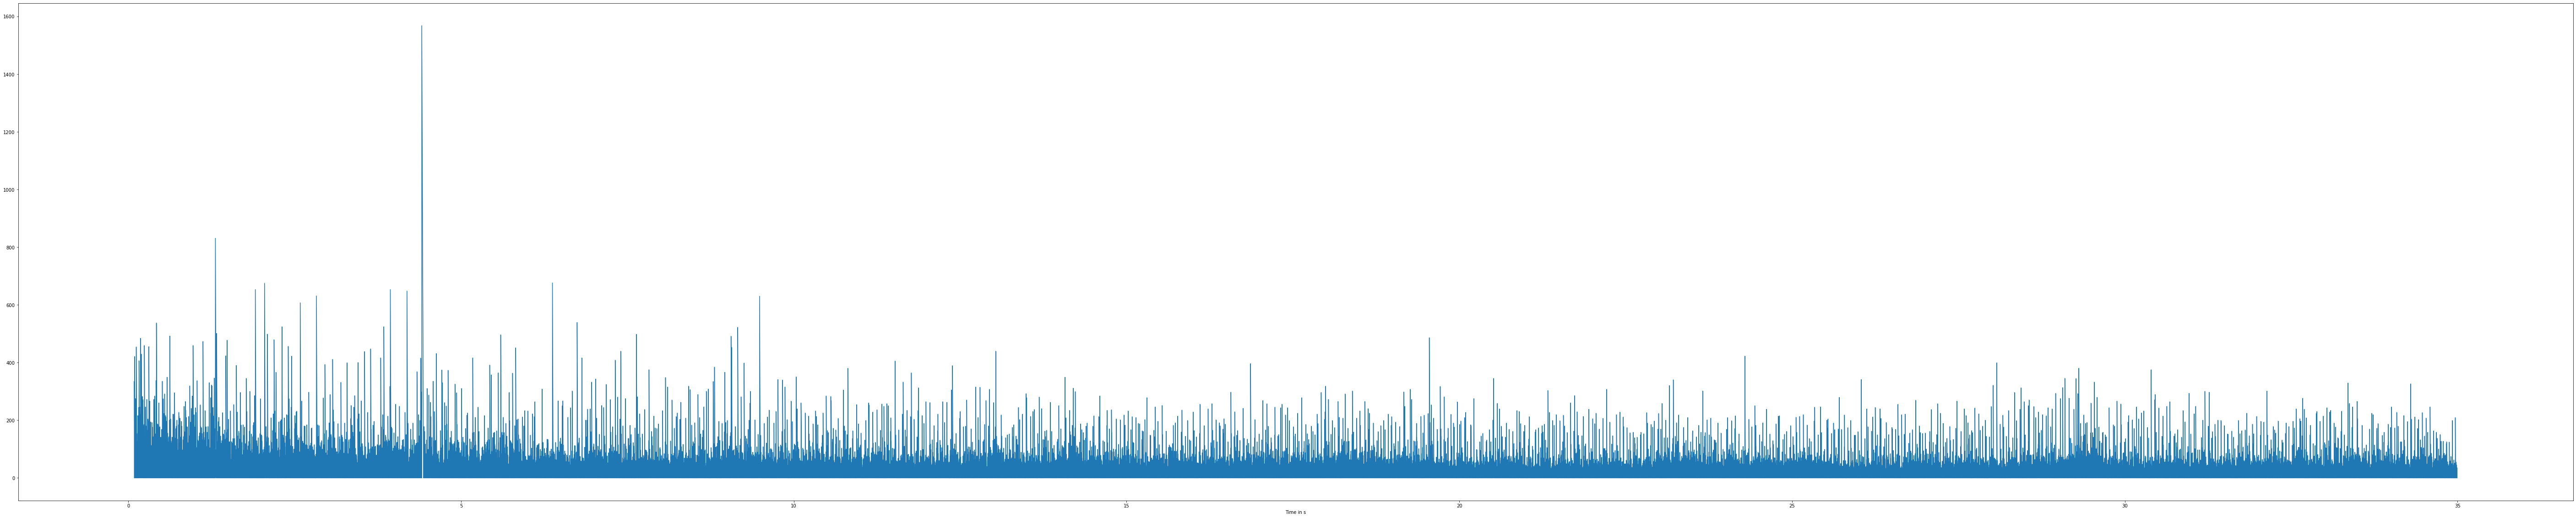

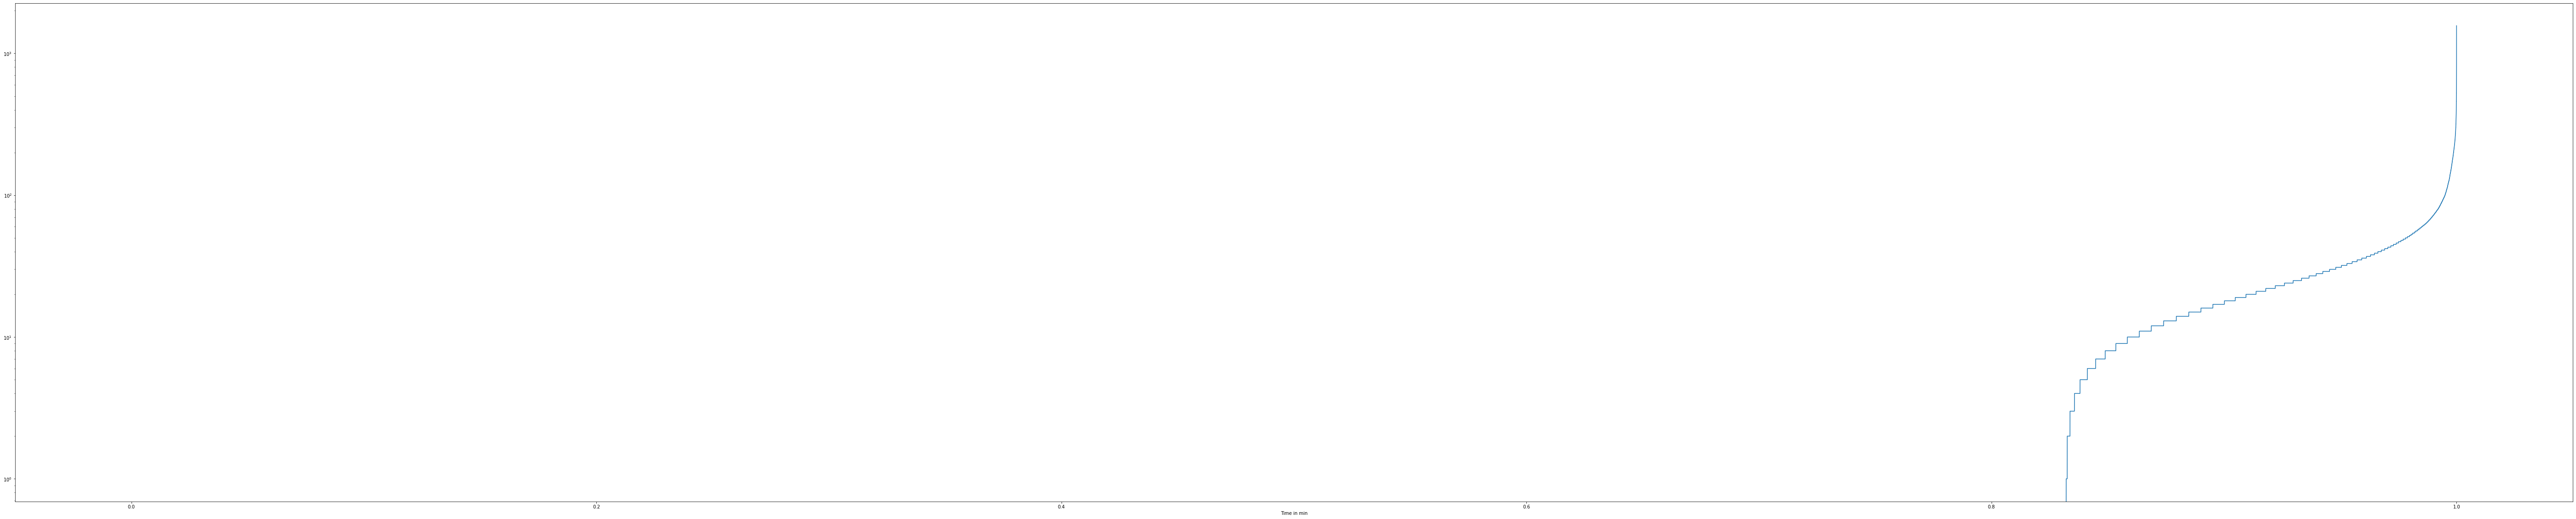

produced received:
Got avg = 4.99 ms; median 0.00 ms; std 17.89 ms; min 0 ms; max 1568 ms; 90% 17.00 ms; 95% 31.00 ms; 99% 72.00 ms; 99.9% 218.00 ms




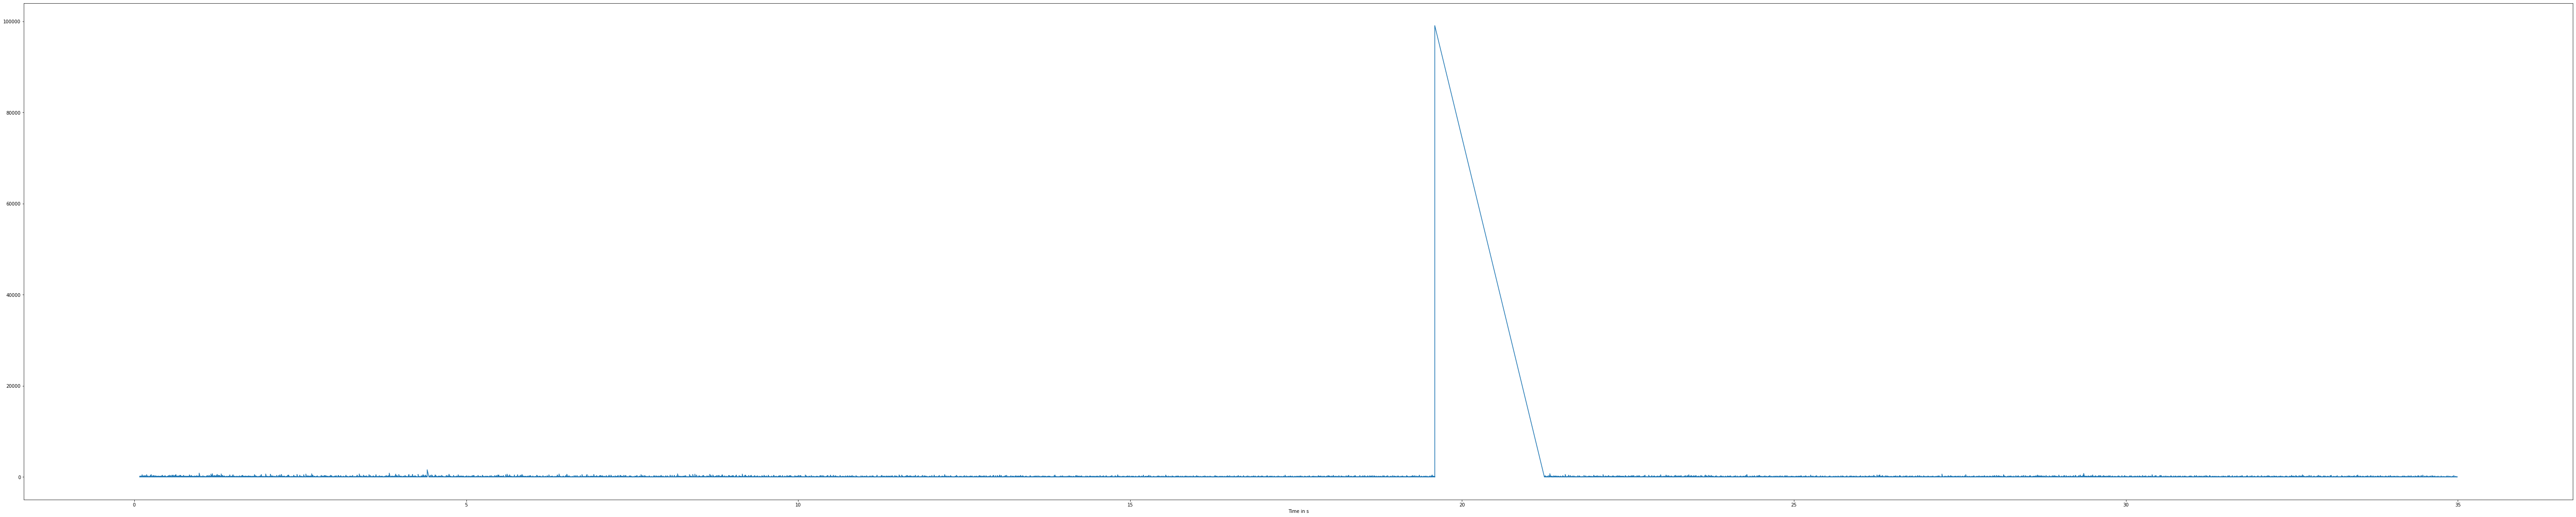

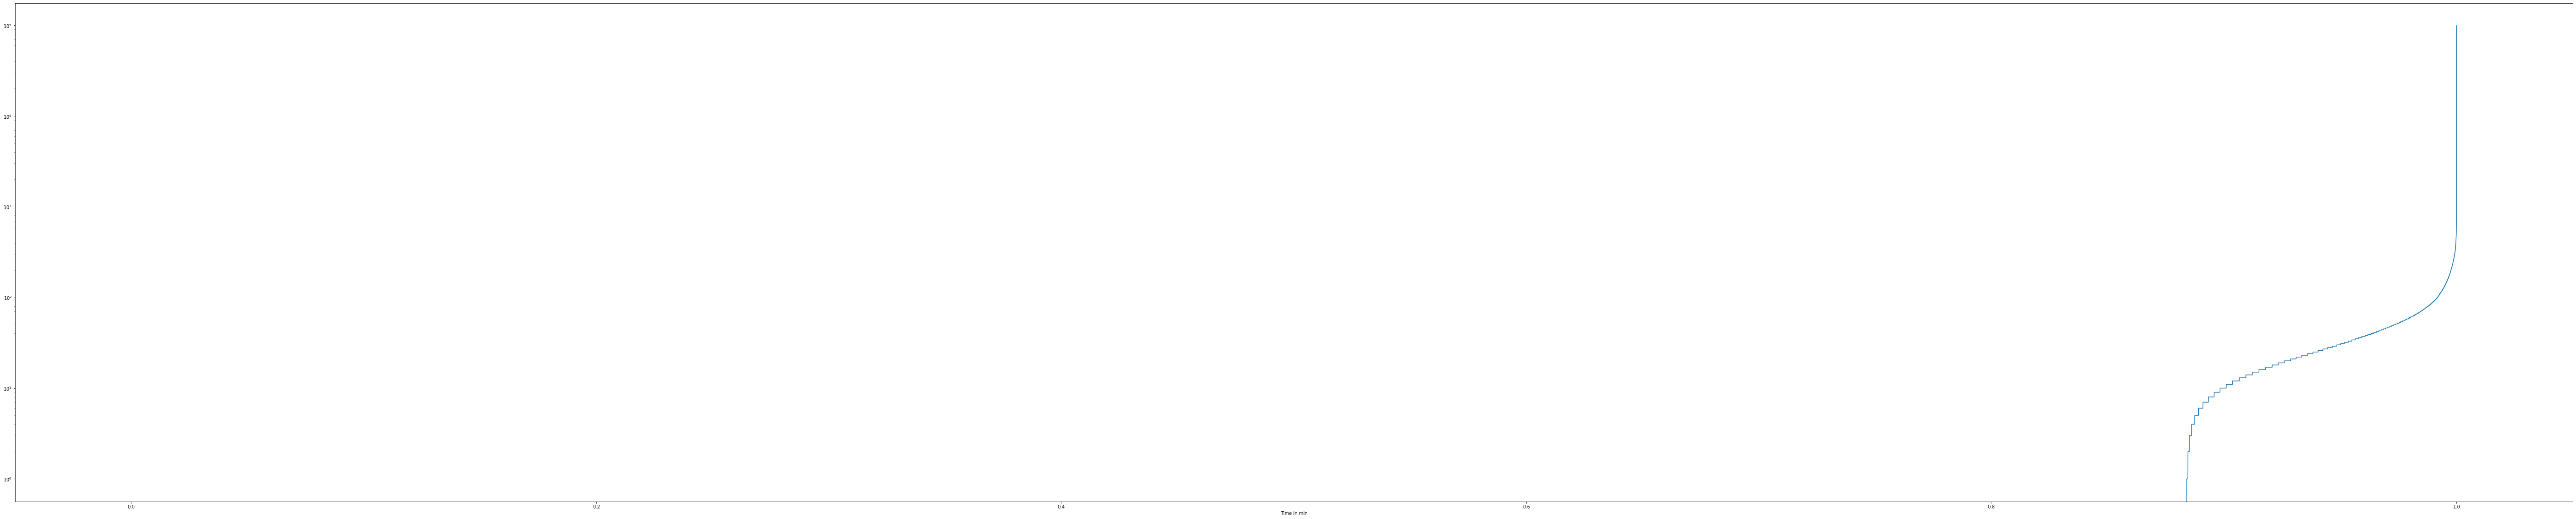

filtered:
Got avg = 4.99 ms; median 0.00 ms; std 154.38 ms; min 0 ms; max 99055 ms; 90% 10.00 ms; 95% 30.00 ms; 99% 90.00 ms; 99.9% 282.00 ms




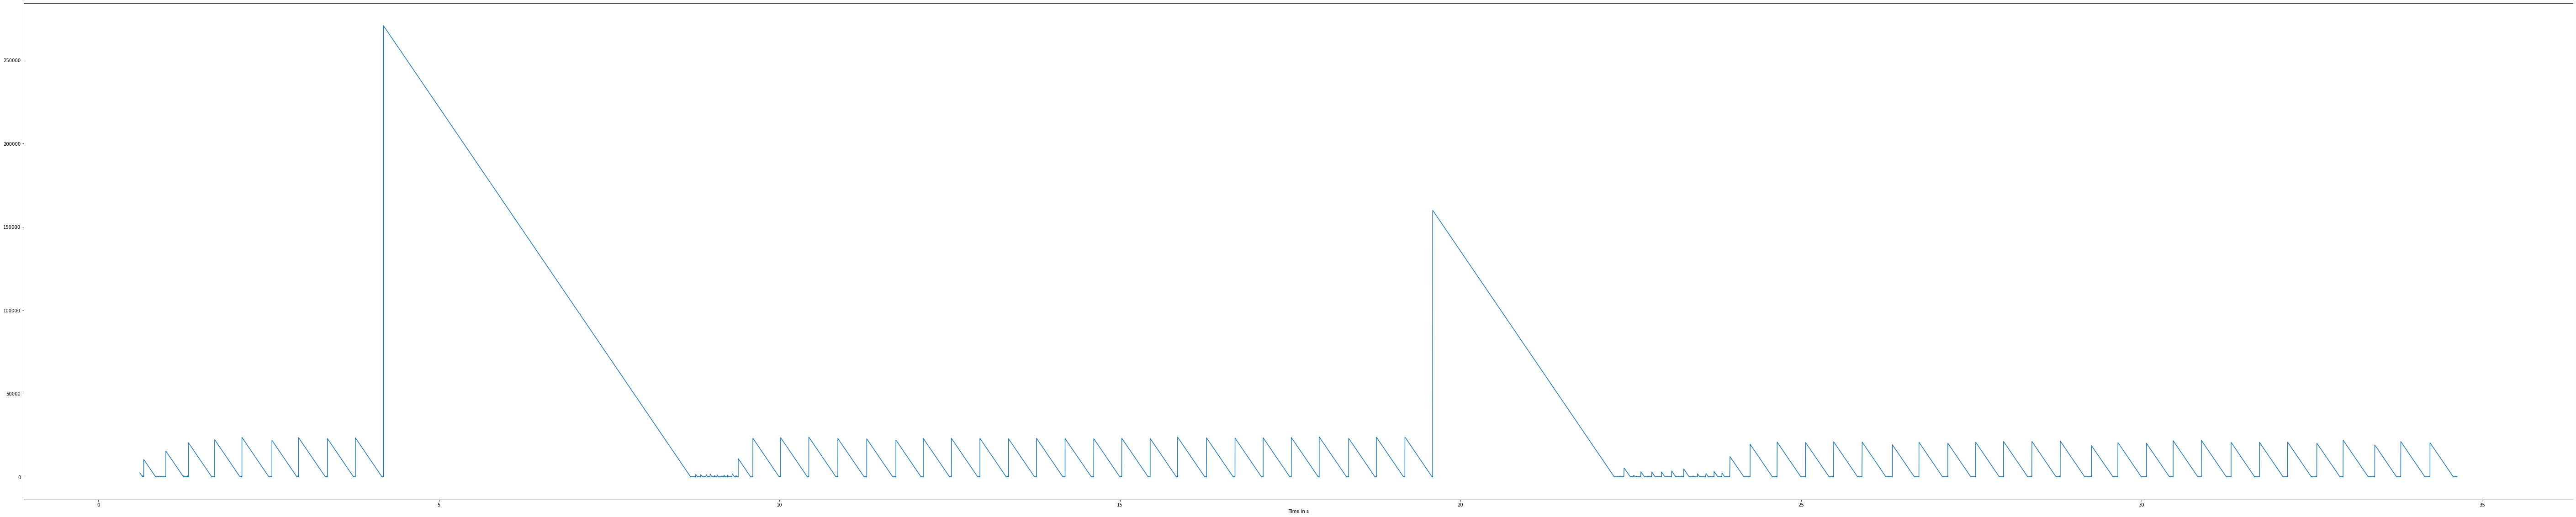

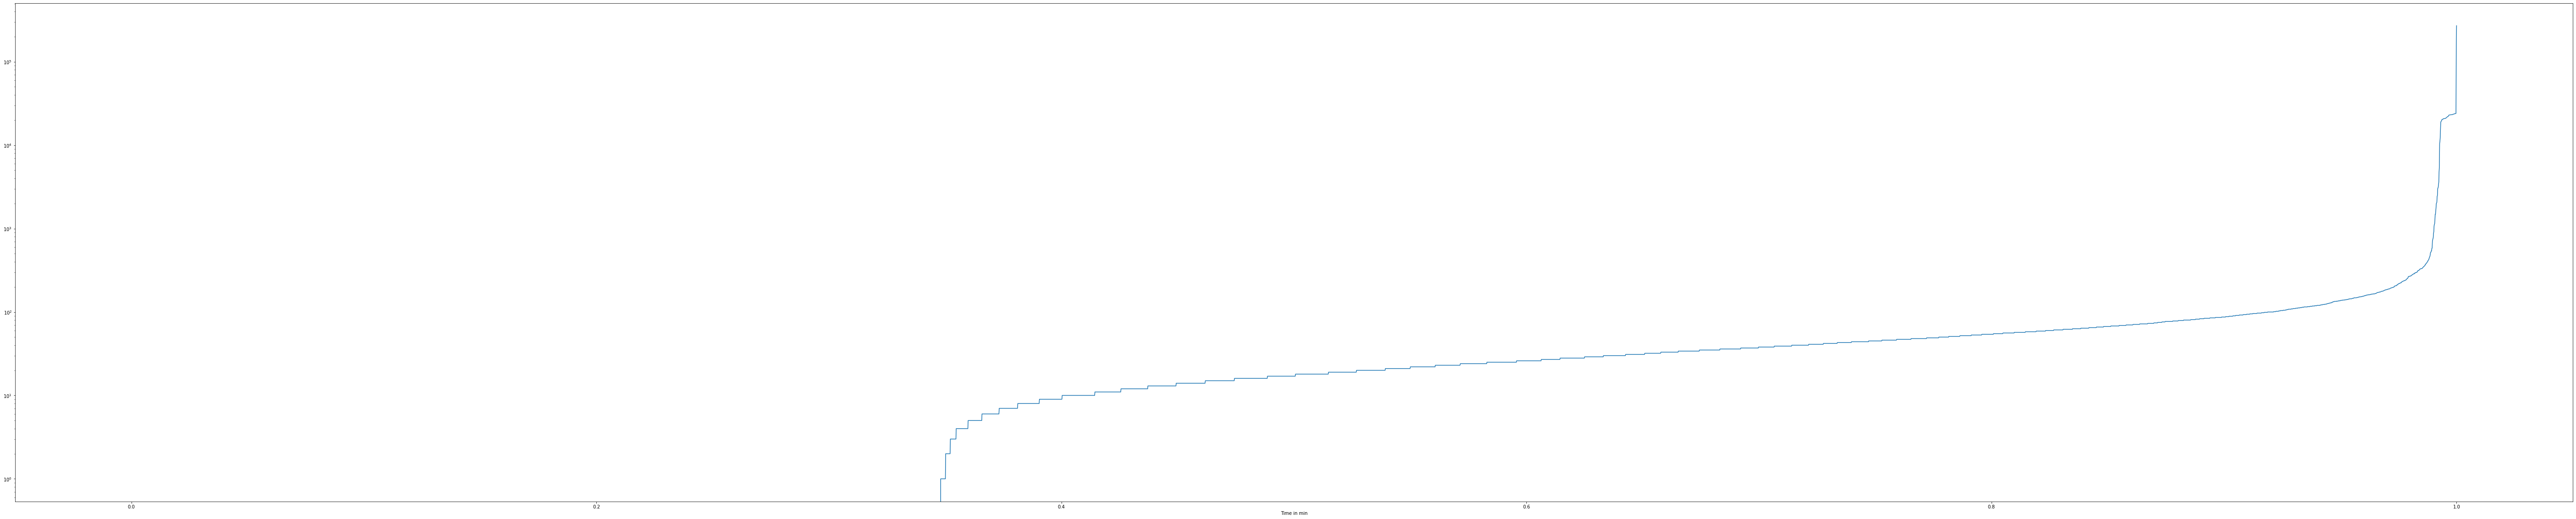

Got avg = 243.57 ms; median 17.00 ms; std 3885.40 ms; min 0 ms; max 270607 ms; 90% 87.00 ms; 95% 137.00 ms; 99% 802.00 ms; 99.9% 23687.29 ms




In [20]:
def avgMedStdArivalTime(df, column):
    df = df.to_numpy()[:,column].astype(int)
    #print(df)
    diff = df[1:,]-df[:-1,]
          
    return extractAvgMedStdMinMaxFromArray(diff, df[:-1,])
    
def getArivalInfos():
    text = "%s:\nGot %s\n\n"
    print(text %("produced", avgMedStdArivalTime(produced_generated_df, 3)))
    print(text %("produced received", avgMedStdArivalTime(produced_recieved_df, 0)))
    print(text %("filtered", avgMedStdArivalTime(filtered_df, 0)))
    print(text %("warning", avgMedStdArivalTime(warnings_df, 0)))
    
getArivalInfos()

## Check Produced

### How long does it take until a produced record is acknowledged by kafka

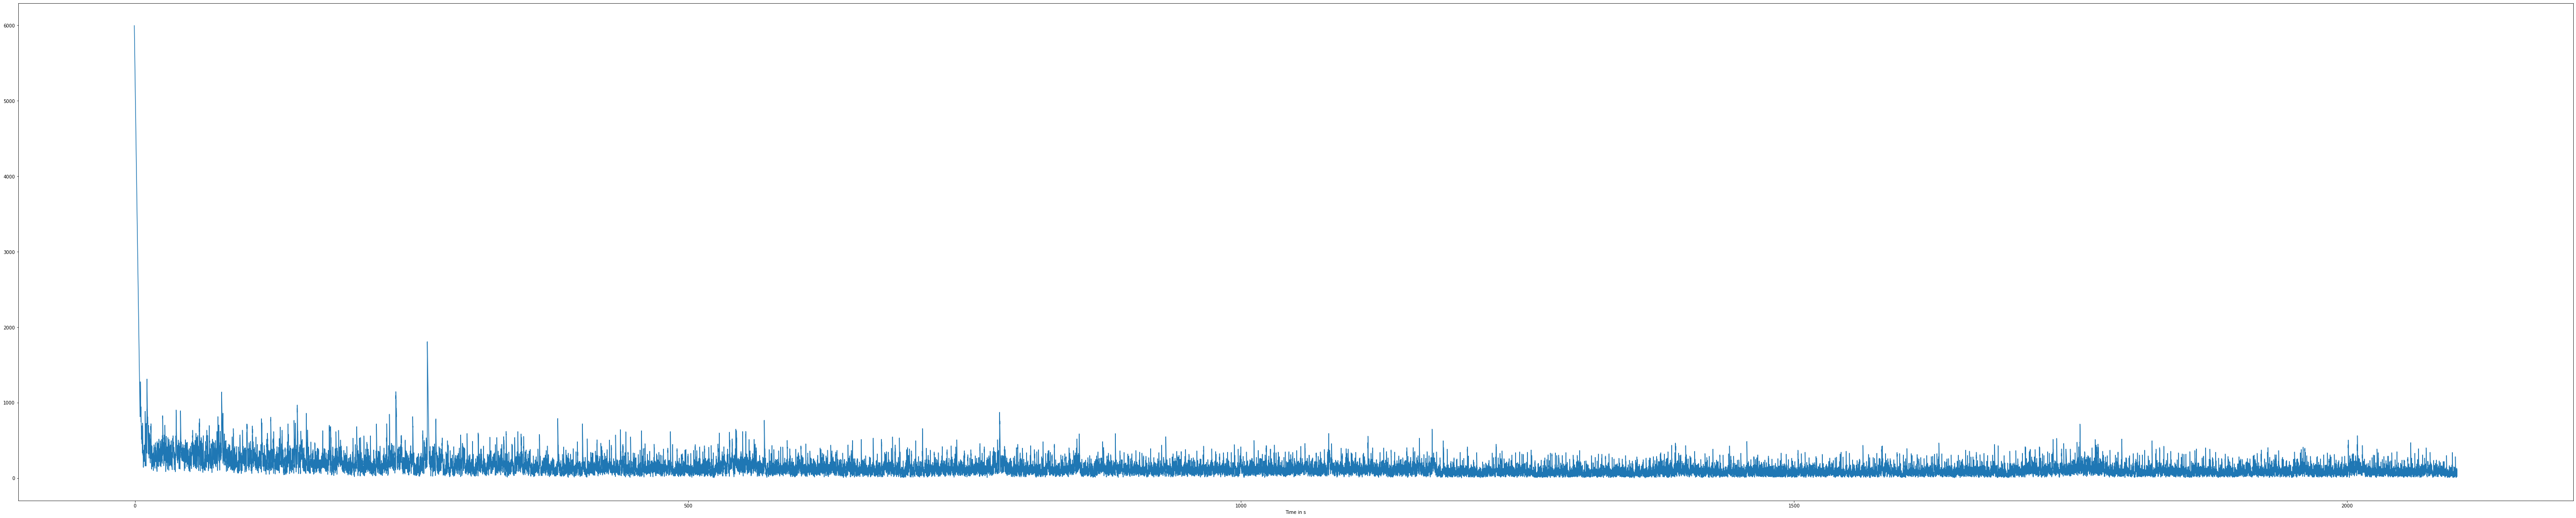

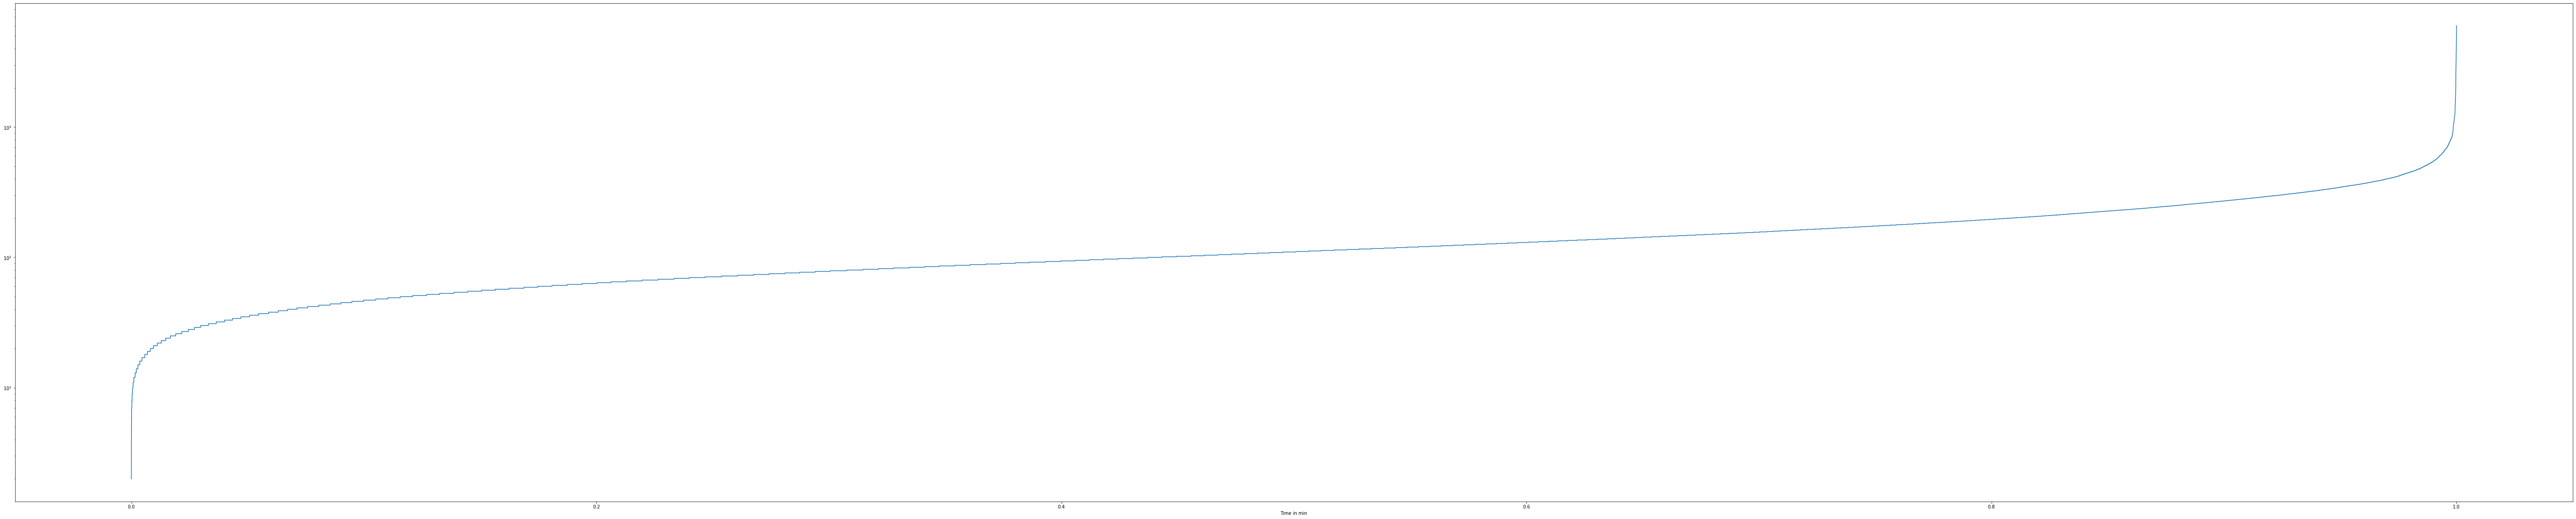

Produced data was received by Kafka after: avg = 141.36 ms; median 110.00 ms; std 126.76 ms; min 2 ms; max 5996 ms; 90% 271.00 ms; 95% 345.00 ms; 99% 546.00 ms; 99.9% 1140.00 ms


In [10]:
def kafkaAck(df):
    ack = df.to_numpy()[:,0].astype(int)
    send = df.to_numpy()[:,3].astype(int)
    diff = ack - send
    return extractAvgMedStdMinMaxFromArray(diff, send)
    
print("Produced data was received by Kafka after: %s" %kafkaAck(produced_recieved_df))

### check validity of produced data

In [11]:
def validate(df):
    df = df.to_numpy()[:,0:4]
    
    lastRow = df[0]
    error = False
    
    l = len(df)
    
    f = IntProgress(min=0, max=100) # instantiate the bar
    display(f)
    i = 0
    
    for x in df[1:]:
        
        i += 1
        cp = int((i / float(l)) * 100)
        
        f.value = cp
            
        if(np.sum(x >= lastRow) != 4):
            error = True
            print("Error:")
            print(lastRow)
            print(x)
        if(lastRow[2] + 1 != x[2]):
            print("Offset %i increased not by 1" %lastRow[2])
            
        lastRow = x
    if(not error):
        print("Valid")
        
    f.value = 100
        
validate(produced_recieved_df)

IntProgress(value=0)

Valid


### Time between the last step and the next

Produced -> Filtered


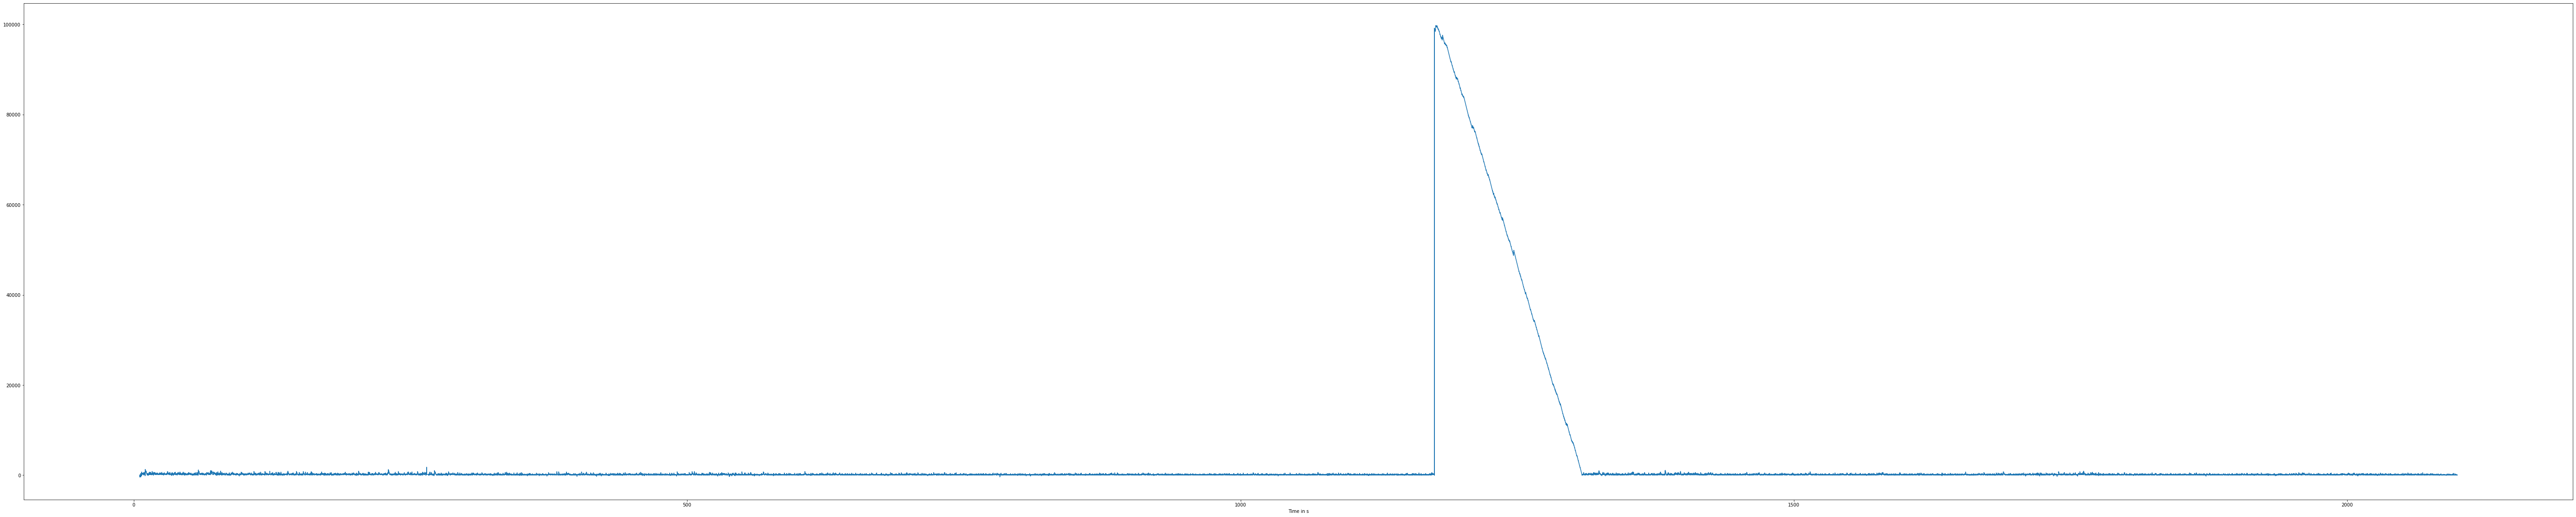

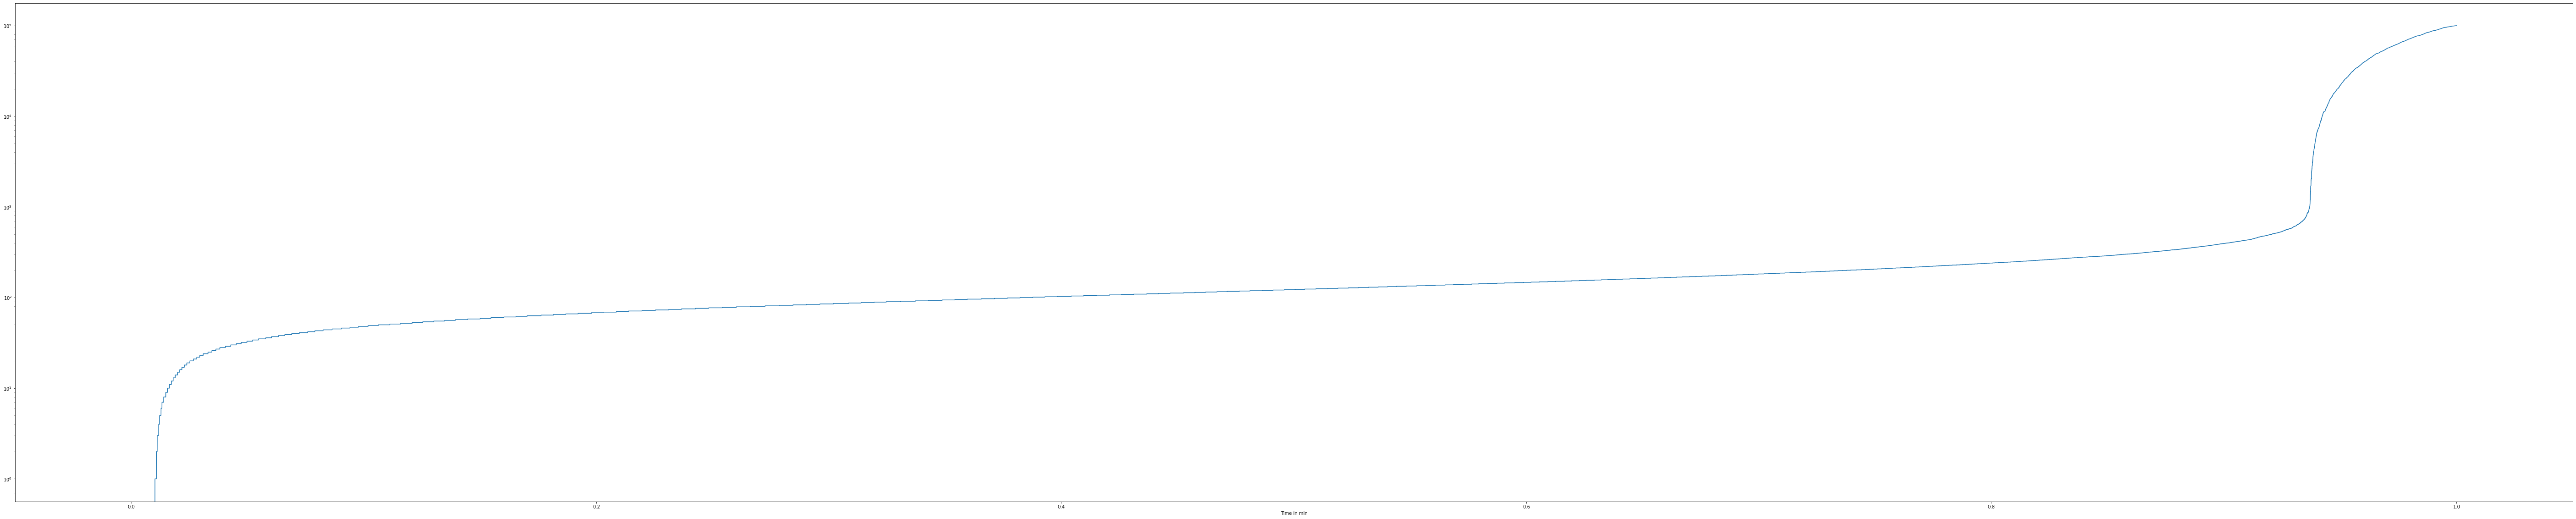

Filtered data was received by a consumer after the produced data was received: avg = 3446.20 ms; median 122.00 ms; std 14708.38 ms; min -402 ms; max 99715 ms; 90% 395.00 ms; 95% 22000.00 ms; 99% 87828.00 ms; 99.9% 99157.00 ms


In [12]:
def extractDiffBetweenTwoTables(a,b,keyA,keyB, sortBy, valueA, valueB):
    joined = a.set_index(keyA).add_prefix('a_').join(b.set_index(keyB).add_prefix('b_')).sort_values("b_" + sortBy, ascending = True)

    diff = joined['a_' + valueA].to_numpy() - joined['b_' + valueB].to_numpy()
    return diff, joined['b_' + valueB].to_numpy(), joined

print("Produced -> Filtered")
diff, timestamps, _ = extractDiffBetweenTwoTables(filtered_df, produced_recieved_df, 'Data.Offset', 'Kafka.Offset', "Consumer.Time", 'Consumer.Time', 'Consumer.Time')
print("Filtered data was received by a consumer after the produced data was received: %s" %extractAvgMedStdMinMaxFromArray(diff, timestamps))

Negative values are possible, a node can receive the warnings before the filtered, it depends on the position in cluster an other aspects

Filtered -> Warning


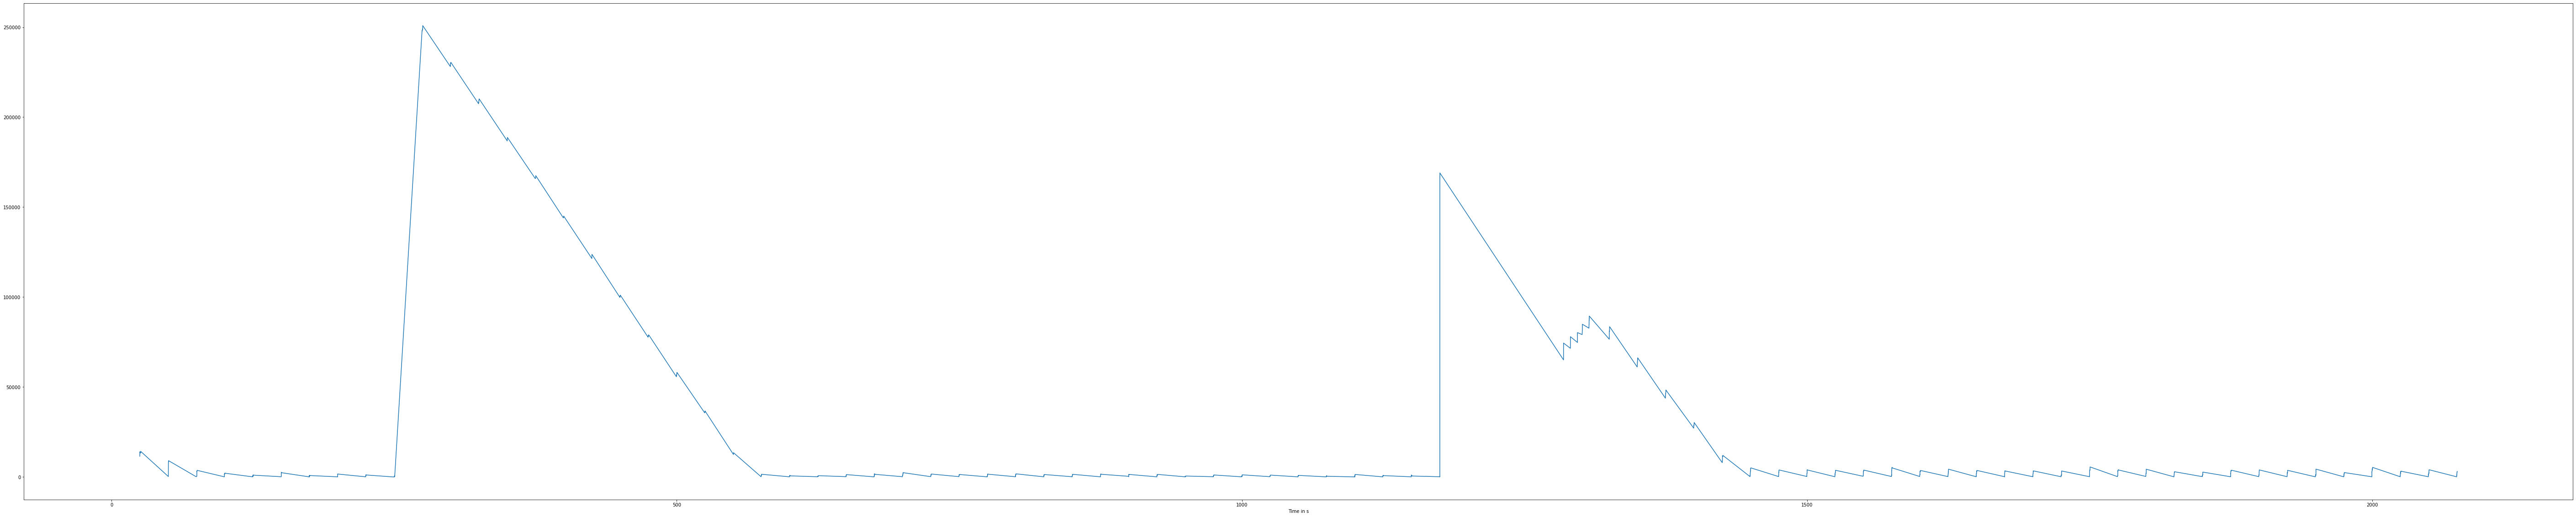

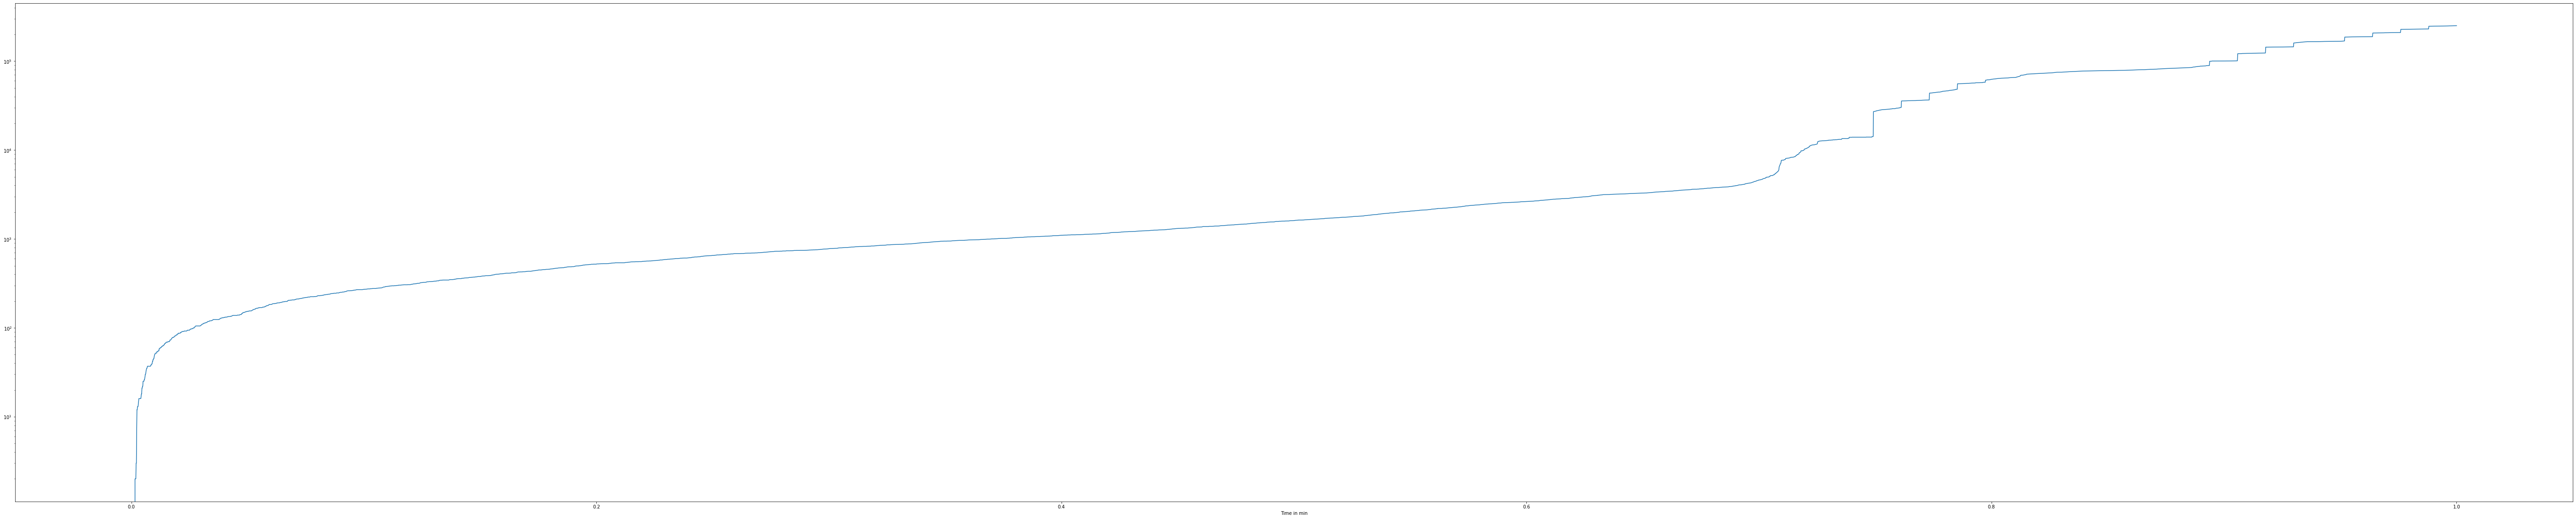

Warning data was received by a consumer after the filtered data was received: avg = 29429.16 ms; median 1609.00 ms; std 57380.24 ms; min -67 ms; max 250908 ms; 90% 100493.00 ms; 95% 167495.00 ms; 99% 247761.84 ms; 99.9% 250316.39 ms
Produced -> Warnings


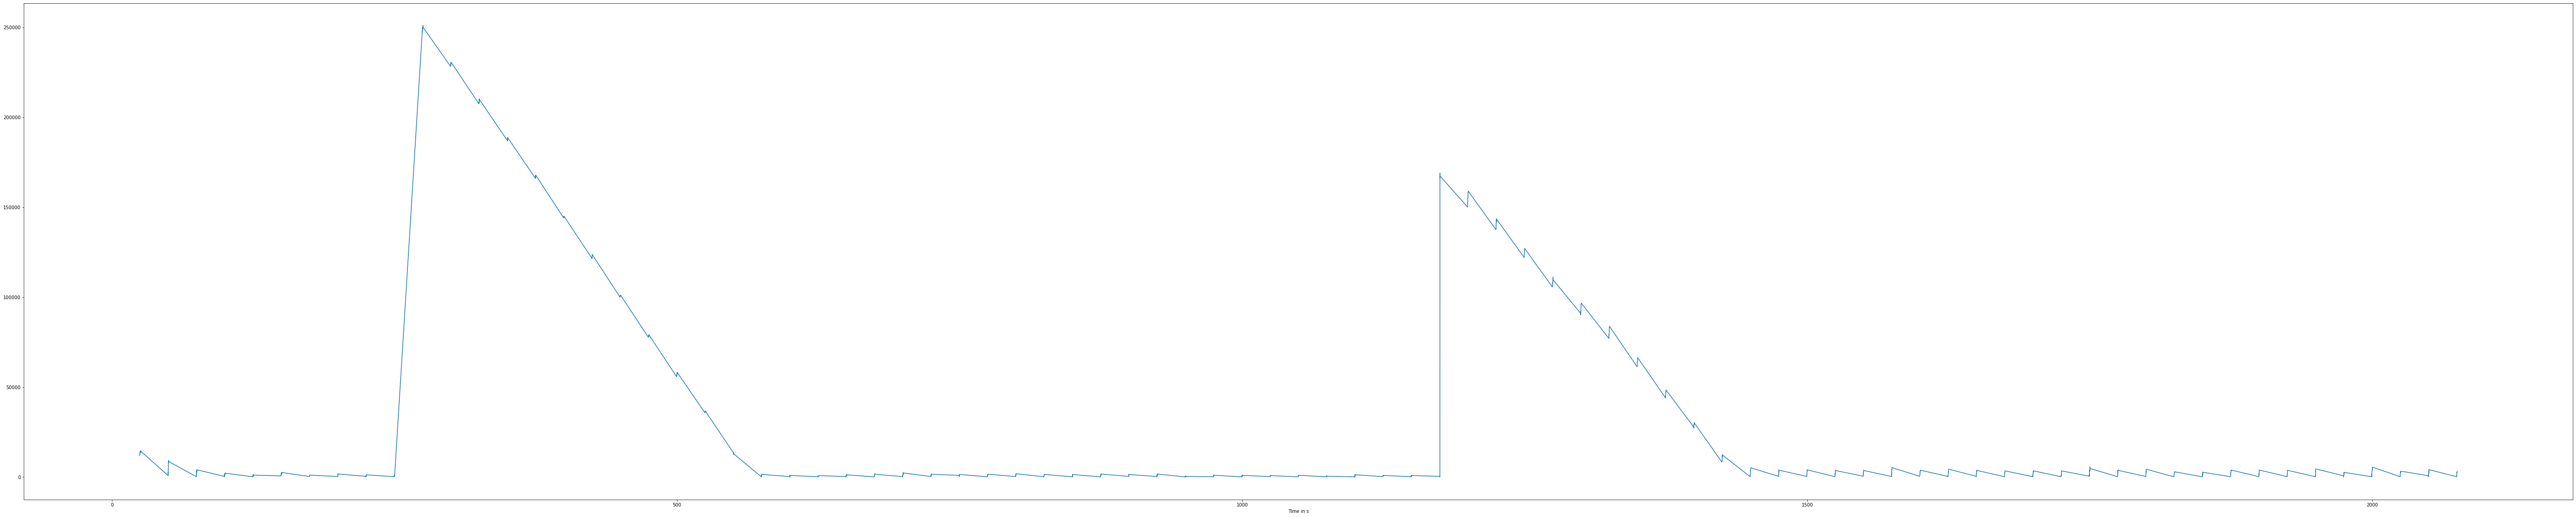

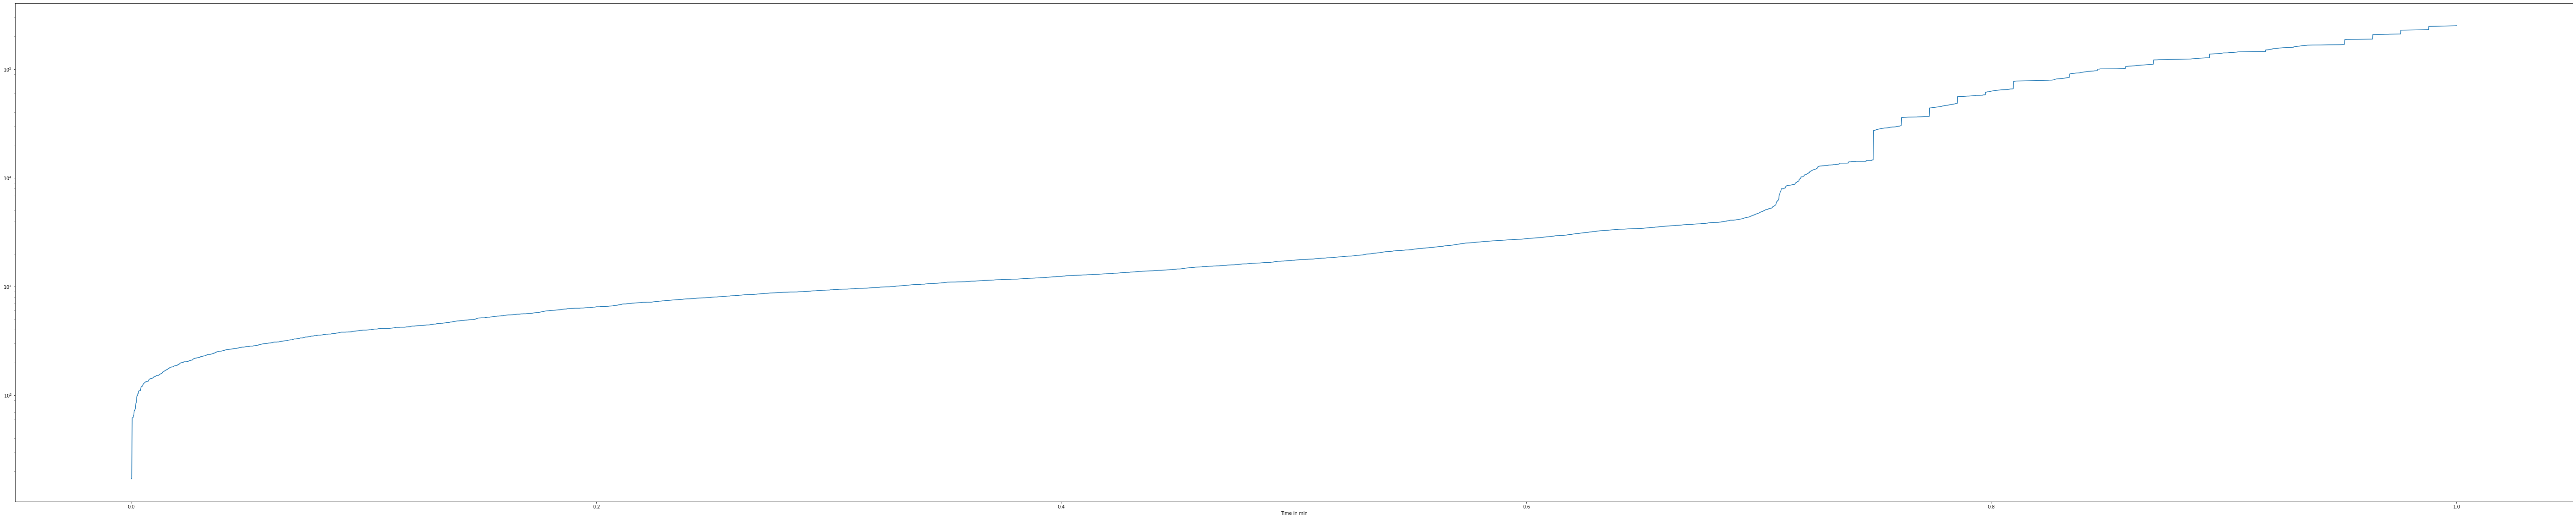

Warnings data was received by a consumer after the produced data was received: avg = 32353.86 ms; median 1743.00 ms; std 60925.60 ms; min 17 ms; max 250961 ms; 90% 140956.00 ms; 95% 167796.30 ms; 99% 247857.84 ms; 99.9% 250369.39 ms


In [13]:
#In warnings Record.BeginOffset and Record.EndOffset are the related filtered offsets! There is no guarantee that these values are the same!!
warnings_filtered_joined = warnings_df.set_index("Record.BeginOffset").join(filtered_df.add_prefix('fb_').set_index("fb_Kafka.Offset")).set_index("Record.EndOffset").join(filtered_df.add_prefix('fe_').set_index("fe_Kafka.Offset"))

print("Filtered -> Warning")
diff = (warnings_filtered_joined["Consumer.Time"] - warnings_filtered_joined["fb_Consumer.Time"]).to_numpy()
diff, timestamps = removeNaN(diff, warnings_filtered_joined["fb_Consumer.Time"].to_numpy())
print("Warning data was received by a consumer after the filtered data was received: %s" %extractAvgMedStdMinMaxFromArray(diff, timestamps))

print("Produced -> Warnings")
diff, timestamps, prod_warning_join = extractDiffBetweenTwoTables(warnings_filtered_joined, produced_recieved_df.add_prefix('pr_'), 'fb_Data.Offset', 'pr_Kafka.Offset', "pr_Consumer.Time", 'Consumer.Time', 'pr_Consumer.Time')
diff, timestamps = removeNaN(diff, timestamps)
print("Warnings data was received by a consumer after the produced data was received: %s" %extractAvgMedStdMinMaxFromArray(diff, timestamps))

## Data loss produced to filter

In [14]:
def calcDataLoss(df1, df1OffsetColumn, df2, df2OffsetColumn):
    df1Offsets = df1.to_numpy()[:,df1OffsetColumn].astype(int)
    df2Offsets = df2.to_numpy()[:,df2OffsetColumn].astype(int)
    
    errors = {}
        
    count = {}
    
    for x in df1Offsets:
        
        count[x] = 0

        
        #count = np.sum(df2Offsets == x)
        
        #if(count != 1):
        #    errors[count] = errors.get(count, 0) + 1
        
    for x in df1Offsets:
        count[x] = count[x] + 1
        
    for k, v in count.items():
        if v != 1:
            errors[count] = errors.get(count, 0) + 1
    
    out = "Received records "
    losses = False
    for k, v in errors.items():
        out += "%ix for %i times; " %(k,v)
        losses = True
    
    if(losses):
        print(out)
    else:
        print("The expected data was received exactly once.")
    
calcDataLoss(produced_generated_df, 0, filtered_df, 3)    

The expected data was received exactly once.


## Latency produced - warning

As the filter uses a median filter with size 5 it needs 3 outliers to detect a change. otherwise it is just skipped. ==> there must be a latency of at least (3*5ms) = 15ms

### Check all anomalies were detected

In [15]:
filterOver10 = filtered_df[filtered_df["Data.Measurement"] > 1.0]

filterOver10Joined = filterOver10.add_prefix('filtered_').set_index("filtered_Kafka.Offset").join(warnings_df.add_prefix('warnings_').set_index("warnings_Record.BeginOffset"))
noBelongingWarning = filterOver10Joined[filterOver10Joined["warnings_Consumer.Time"].isna()]

print("For %d / %d anomalies there were no belonging warnings" %(len(noBelongingWarning),len(filterOver10)))

For 0 / 8383 anomalies there were no belonging warnings


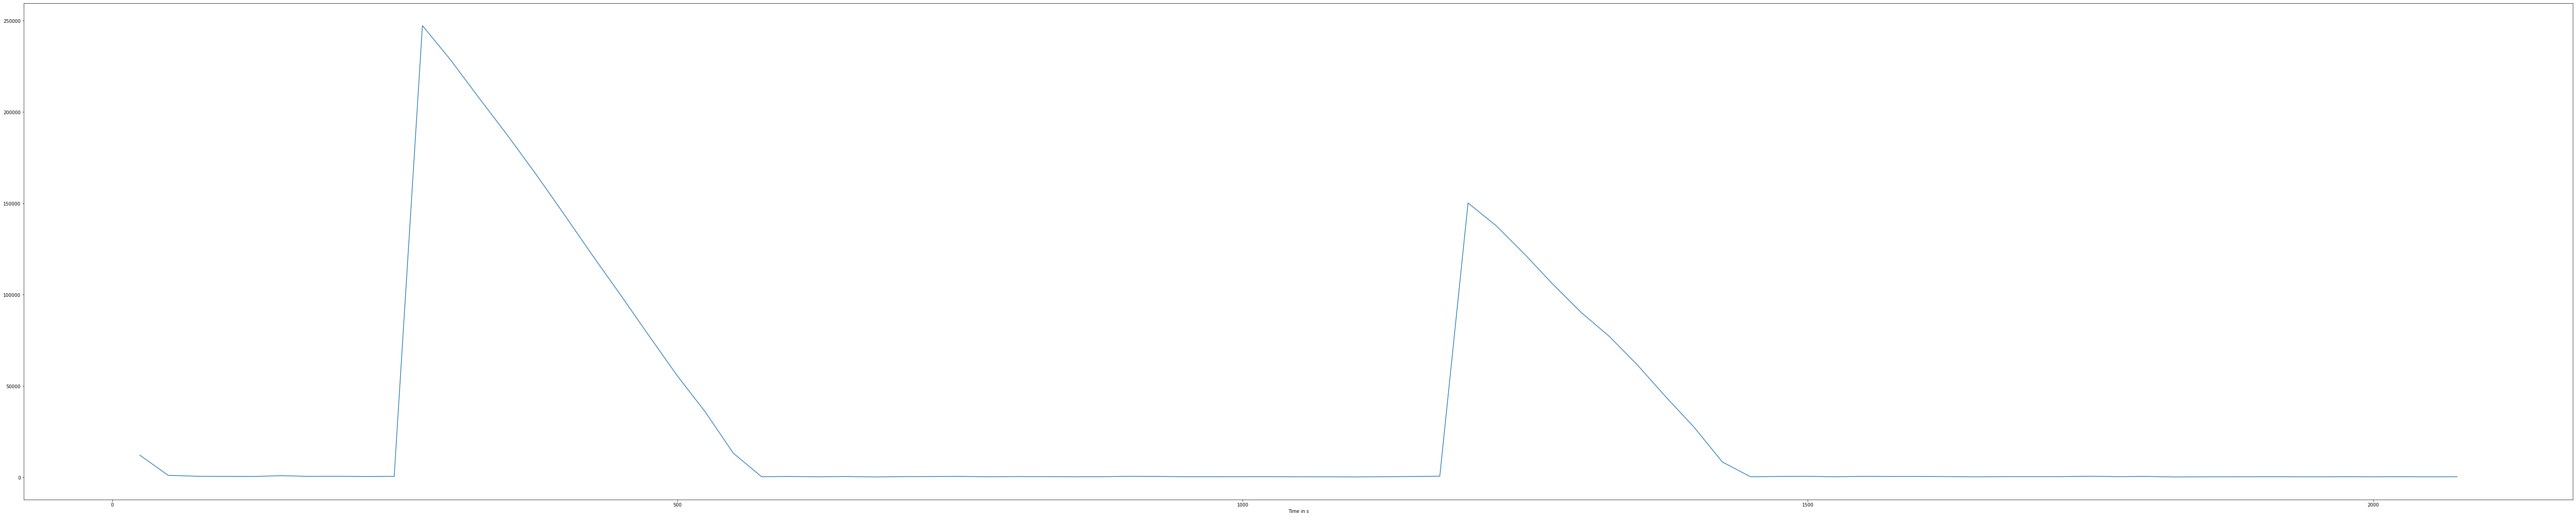

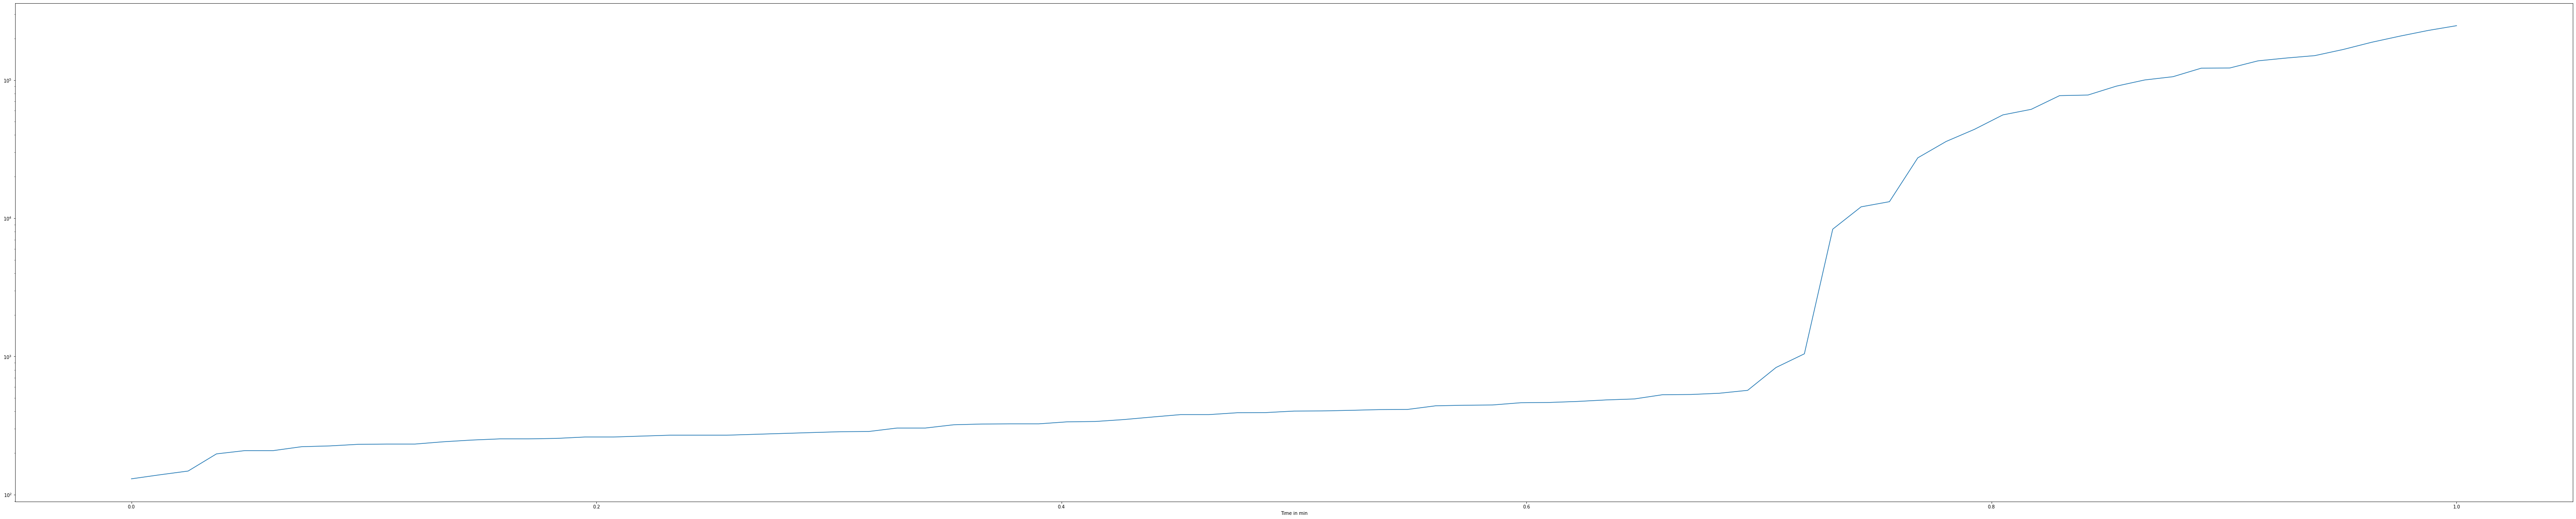

Anomalies were detected by Kafka after: avg = 29438.40 ms; median 402.00 ms; std 59315.71 ms; min 130 ms; max 247299 ms; 90% 122097.20 ms; 95% 164671.10 ms; 99% 231823.14 ms; 99.9% 245751.41 ms


In [16]:


set_pandas_display_options()
#received and produced
pr_rc = produced_generated_df.add_prefix('produced_generated_').set_index("produced_generated_Kafka.Offset").join(produced_recieved_df.add_prefix('produced_recieved_').set_index("produced_recieved_Kafka.Offset")).reset_index()

#received and produced and filtered
pr_rc_fi = pr_rc.set_index("produced_generated_Kafka.Offset").join(filtered_df.add_prefix('filtered_').set_index("filtered_Data.Offset")).reset_index()

#changes and received and produced and filtered
mc_pg_pr_fi = modelchange_df.add_prefix('modelchange_').set_index("modelchange_producedElements").join(pr_rc_fi.set_index("produced_generated_ProducedElements")).reset_index().rename(columns={'modelchange_producedElements': 'producedElements'})

#merge all with warnings
fullJoin = mc_pg_pr_fi.set_index("filtered_Kafka.Offset").join(warnings_df.add_prefix('warning_').set_index("warning_Record.BeginOffset")).reset_index()

fullJoinOver10 = fullJoin[fullJoin["modelchange_value"] > 1]

diff = (fullJoinOver10['warning_Consumer.Time'] - fullJoinOver10['produced_generated_Producer.Timestamp']).to_numpy()

timestamps = fullJoinOver10['produced_generated_Producer.Timestamp'].to_numpy()

if (np.isnan(diff[-1])):
    diff = diff[:-1]
    timestamps = timestamps[:-1]
    
diffNew = diff

print("Anomalies were detected by Kafka after: %s" %extractAvgMedStdMinMaxFromArray(diff, timestamps))
#fullJoin[fullJoin["warning_Consumer.Time"].isna()]

## DEBUG ##

def getBetween(array, offset, field = "produced_generated_Kafka.Offset", range = 5):
    return array[(array[field] > offset - range) & (array[field] < offset + range)]
    
getBetween(pr_rc_fi, 15000, "produced_generated_Kafka.Offset")

getBetween(warnings_df, 15000, "Record.BeginOffset",10)

In [17]:
#getBetween(filtered_df, 10101, "Kafka.Offset")

# Old Version

def calcLatencyProduceWarning(modelchange_df, warnings_df):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        if int(x[1]) == 0 :
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df))

def calcLatencyProduceWarning(modelchange_df, warnings_df, amplitude, periodLength):
    m = modelchange_df.to_numpy()
    w = warnings_df.to_numpy()
    lastChange = m[0]

    open = False
    s = None
    
    diff = []
    
    for x in m:
        if x[1] == amplitude and x[2] == periodLength:
            open = False
            
            # search warnings
            a = w[:,6] >= lastChange[0]

            b = w[:,7] <= x[0]
            
            inner = np.logical_and(a,b)
            
            leftOuter = np.logical_and(w[:,6] <= lastChange[0], w[:,7] >= lastChange[0])
            rightOuter = np.logical_and(w[:,6] <= x[0], w[:,7] >= x[0])

            fullRange = np.logical_or(leftOuter, inner)
            fullRange = np.logical_or(fullRange, rightOuter)
            
            if s is None:
                fullRange.astype(int)
                s = fullRange
            else:
                s = np.add(s,fullRange.astype(int))
            
            matching = w[fullRange]     
            
            #first recognition
            r = min(matching[:,0])
            diff.append(r - lastChange[0])
            
        else:
            #skip two changes without a reset
            if not open:
                lastChange = x
            open = True
        
    if not np.all(s == 1):
        print("Didn't match all recognized changes! With 0 weren't matched:")
        with np.printoptions(threshold=np.inf):
            print(s)
        
    diff = np.array(diff)
    
    return extractAvgMedStdMinMaxFromArray(diff)

print("Anomalies were detected by Kafka after: avg = %.2f ms; median %.2f ms; std = %.2f ms, further min was %d ms and max %d ms" %calcLatencyProduceWarning(modelchange_df, warnings_df, 3, 1000))